In [6]:
from matplotlib import pyplot as plt
import numpy as np
import re

# Select all files to load via regex
regex = ".*"

# Files to load. t = nzm_timesteps, l = lut_depth, s = samples, w = reward weights
files = [
    "lut_t=1_l=1_s=3_w=1",
    "lut_t=2_l=1_s=3_w=01",
    "lut_t=2_l=1_s=3_w=11",
    "lut_t=3_l=1_s=3_w=001",
    "lut_t=3_l=1_s=3_w=011",
    "lut_t=3_l=1_s=3_w=111",

    "rnn_t=1_s=3_w=1",
    "rnn_t=2_s=3_w=01",
    "rnn_t=2_s=3_w=11",
    "rnn_t=3_s=3_w=001",
    "rnn_t=3_s=3_w=011",
    "rnn_t=3_s=3_w=111",
]

fidelities_each = []
loaded_files = []
for file in files:
    if not re.match(regex, file):
        continue

    data = np.load(f"{file}.npz")
    fidelities_each.append(data)
    loaded_files.append(file)

baseline_fidelities = np.load("baseline_fidelities.npz")["fidelities"]

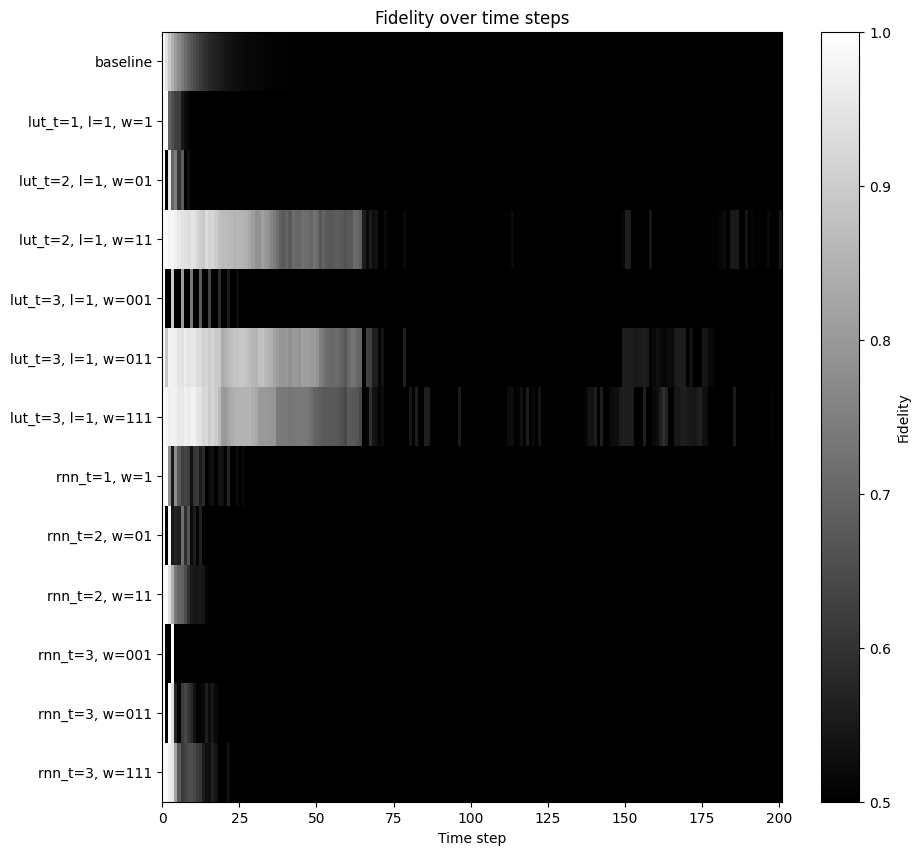

In [10]:
# Read fidelities into matrix and plot 2D graph
from matplotlib.colors import Colormap


label_each = []
first_value = None
for value in fidelities_each[0].values():
    first_value = value
    break
fidelities_mat = np.zeros((len(fidelities_each), len(first_value)))

fig, ax = plt.subplots(1,1, figsize=(10,10))
for i, (filename, fidelities) in enumerate(zip(loaded_files, fidelities_each)):
    color = (
        "lightgrey" if "grape" in filename else
        "tab:blue"  if "lut" in filename else
        "tab:orange" # rnn
    )

    keyword = (
        "fidelities_grape" if "grape" in filename else
        "fidelities_lut"  if "lut" in filename else
        "fidelities_rnn" # rnn
    )

    F = fidelities[keyword]

    # extract variables from filename
    protocol = re.search(r'^(grape|lut|rnn)', filename).group(1)
    t = int(re.search(r't=(\d+)', filename).group(1))
    s = int(re.search(r's=(\d+)', filename).group(1))
    w = re.search(r'w=(\d+)', filename).group(1)

    if protocol == "lut":
        l = int(re.search(r'l=(\d+)', filename).group(1))
        label = f"{protocol}_t={t}, l={l}, w={w}"
    else:
        label = f"{protocol}_t={t}, w={w}"

    fidelities_mat[i,:] = F
    label_each.append(label)

# Add baseline fidelities as first row
fidelities_mat = np.vstack([baseline_fidelities, fidelities_mat])
label_each = ["baseline"] + label_each

fidelities_mat[fidelities_mat < 0.5] = 0.5  # for better contrast in colormap
im = ax.imshow(
    fidelities_mat,
    aspect="auto",
    cmap="gray",
    extent=[0, fidelities_mat.shape[1], fidelities_mat.shape[0], 0],
    interpolation="none",
)
fig.colorbar(im, ax=ax, label="Fidelity")

#ax.set_xlim(0, 100)
ax.set_xlabel("Time step")
ax.set_yticks(np.arange(len(label_each))+0.5)
ax.set_yticklabels(label_each)
ax.set_title("Fidelity over time steps")

fig.savefig("fidelity_comparison.png", dpi=300)